In this notebook two deep learning methods are tested for air pollution prediction. **LSTM** and **CNN**. 

Univariate and Multivariate models are created to compare how a larger number of features affects the accuracy of the forecasts.


In the univariate models only values from previous days are used to make a prediction, whereas, in the multivariate models, weather forecast features are also taken in account for the prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

In [2]:
def split_ts_by_window(time_series, n_steps):
    window, output = list(), list()
    
    #UNIVARIATE MODEL
    if(isinstance(time_series, pd.Series)):
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series)-1:
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE WHICH IS THE OBSERVATION AFTER THE END OF THE WINDOW
            input_features, output_pollutant = time_series[i:window_limit], time_series[window_limit]

            window.append(input_features)
            output.append(output_pollutant)
    
    #MULTIVARIATE MODEL
    else:
        for i in range(len(time_series)):
        
            #'n_steps' IS THE NUMBER OF PREVIOUS OBSERVATIONS I USED TO PREDICT THE NEXT VALUE
            #CREATE A WINDOW OF 'n_steps'
            window_limit = i + n_steps

            #IF THE END OF THE TIME SERIES IS REACHED BREAK THE LOOP
            if window_limit > len(time_series):
                break

            #STORE EACH SEQUENCE OF 'n_steps' OBSERVATIONS TO THE 'window' LIST, WHICH IS GOING TO BE THE MODEL INPUT
            #AND STORE THE OUTPUT VALUE COMING FROM 'n_steps' WINDOW USED

            #THE OUTPUT VALUES ARE THOSE OF THE FIRST COLUMN (POLLUTANT COLLUMN)
            input_features, output_pollutant = time_series[i:window_limit,:], time_series[window_limit-1,0]
            
            window.append(input_features)
            output.append(output_pollutant)
        
    return np.asarray(window).astype('float32'), np.asarray(output).astype('float32')

In [3]:
#GATHER ATHENS DATA FROM ALL AVAILABLE YEARS
Athens_Data = pd.read_csv('Athens_data.csv', index_col=0)

In [4]:
#ATHENS DATA PREVIEW
Athens_Data

,no2,o3,pm10,pm25,so2,temp,dew,humidity,windspeed,winddir
2019-11-07,0.576208,0.470135,0.721311,0.352381,0.000000,0.609467,0.872659,0.692094,0.331906,0.424969
2019-11-08,0.423792,0.470135,0.442623,0.352381,0.039683,0.576923,0.812734,0.647712,0.304069,0.291096
2019-11-09,0.442379,0.454721,0.213115,0.228571,0.039683,0.494083,0.715356,0.664910,0.233405,0.352117
2019-11-10,0.237918,0.516378,0.131148,0.152381,0.039683,0.523669,0.812734,0.758669,0.293362,0.590598
2019-11-11,0.356877,0.375723,0.229508,0.180952,0.039683,0.491124,0.760300,0.740499,0.051392,0.469801
...,...,...,...,...,...,...,...,...,...,...
2022-03-15,0.371747,0.539499,0.327869,0.419048,0.277778,0.213018,0.235955,0.441054,0.334047,0.640722
2022-03-16,0.442379,0.547206,0.426230,0.542857,0.317460,0.230769,0.385768,0.640777,0.331906,0.464508
2022-03-17,0.338290,0.587669,0.459016,0.504762,0.198413,0.310651,0.464419,0.618585,0.453961,0.342777
2022-03-18,0.204461,0.633911,0.295082,0.342857,0.079365,0.198225,0.217228,0.424411,0.588865,0.179016


## Data Preparation for Univariate Models

In [4]:
#DATA PREPARATION FOR UNIVARIATE MODELS

#KEEP ONLY THE POLLUTANTS COLUMNS
cols=['pm25', 'pm10', 'no2', 'o3', 'so2']

#MAKE VALUES NUMERIC
Athens_Data_uni = Athens_Data.loc[:, Athens_Data.columns.intersection(cols)]
Athens_Data_uni = Athens_Data_uni.apply(pd.to_numeric, errors='coerce')

Athens_Data_uni = Athens_Data_uni.fillna(method='bfill')

In [37]:
#UNIVARIATE DATA PREVIEW
Athens_Data_uni

,no2,o3,pm10,pm25,so2
2019-11-07,0.576208,0.470135,0.721311,0.352381,0.000000
2019-11-08,0.423792,0.470135,0.442623,0.352381,0.039683
2019-11-09,0.442379,0.454721,0.213115,0.228571,0.039683
2019-11-10,0.237918,0.516378,0.131148,0.152381,0.039683
2019-11-11,0.356877,0.375723,0.229508,0.180952,0.039683
...,...,...,...,...,...
2022-03-15,0.371747,0.539499,0.327869,0.419048,0.277778
2022-03-16,0.442379,0.547206,0.426230,0.542857,0.317460
2022-03-17,0.338290,0.587669,0.459016,0.504762,0.198413
2022-03-18,0.204461,0.633911,0.295082,0.342857,0.079365


## Data preparation for Multivariate Models

In [7]:
#DATA PREPARATION FOR MULTIVARIATE MODELS

#ALL COLUMNS
Athens_Data.columns

Index(['no2', 'o3', 'pm10', 'pm25', 'so2', 'temp', 'dew', 'humidity',
       'windspeed', 'winddir'],
      dtype='object')

In [8]:
#DECIDE WHICH COLUMNS TO KEEP BASED ON HOW MANY MISSING VALUES THERE ARE. IF A COLUMNS HAS A FEW MISSING VALUES,
#COMPARED TO THE LENGTH OF THE DATAFRAME, THEN KEEP IT. OTHERWISE, DROP IT.

(Athens_Data).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [5]:
#MAKE THE REMAINING COLUMNS NUMERIC
cols=['pm25', 'pm10', 'no2', 'o3', 'so2', 'windspeed', 'humidity', 'winddir', 
      'temp', 'windgust', 'dew']

Athens_Data_multi = Athens_Data.loc[:, Athens_Data.columns.intersection(cols)]
Athens_Data_multi = Athens_Data_multi.apply(pd.to_numeric, errors='coerce')

In [10]:
(Athens_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [6]:
#FILL NAN VALUES WITH BACKWARD FILLING AND CHECK THAT THERE ARE NONE LEFT
Athens_Data_multi = Athens_Data_multi.iloc[1: , :]
Athens_Data_multi = Athens_Data_multi.fillna(method='bfill')

(Athens_Data_multi).isna().sum()

no2          0
o3           0
pm10         0
pm25         0
so2          0
temp         0
dew          0
humidity     0
windspeed    0
winddir      0
dtype: int64

In [9]:
pollutants = ['o3', 'so2', 'no2', 'pm25', 'pm10']
weather_conds = ['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew']

#CREATE FIVE DIFFERENT DATASETS, EACH CONTAINS ONE OF THE POLLUTANTS AND ALL THE WEATHER CONDITIONS
Athens_o3 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'o3'])]
Athens_so2 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'so2'])]
Athens_no2 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'no2'])]
Athens_pm25 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm25'])]
Athens_pm10 = Athens_Data_multi.loc[:, Athens_Data_multi.columns.intersection(['windspeed', 'humidity', 'winddir', 'temp', 'windgust', 'dew', 'pm10'])]

datasets = [Athens_o3, Athens_no2, Athens_so2, Athens_pm10, Athens_pm25]

In [13]:
#MULTIVARIATE DATA PREVIEW
Athens_o3

,o3,temp,dew,humidity,windspeed,winddir
2019-11-08,0.470135,0.576923,0.812734,0.647712,0.304069,0.291096
2019-11-09,0.454721,0.494083,0.715356,0.664910,0.233405,0.352117
2019-11-10,0.516378,0.523669,0.812734,0.758669,0.293362,0.590598
2019-11-11,0.375723,0.491124,0.760300,0.740499,0.051392,0.469801
2019-11-12,0.470135,0.538462,0.846442,0.803051,0.201285,0.588107
...,...,...,...,...,...,...
2022-03-15,0.539499,0.213018,0.235955,0.441054,0.334047,0.640722
2022-03-16,0.547206,0.230769,0.385768,0.640777,0.331906,0.464508
2022-03-17,0.587669,0.310651,0.464419,0.618585,0.453961,0.342777
2022-03-18,0.633911,0.198225,0.217228,0.424411,0.588865,0.179016


# UNIVARIATE CNN

In [15]:
def Uni_CNN():
    preds = []
    tests = []
    
    #n_steps = 7
    n_features = 1

    #CNN UNIVARIATE MODEL
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    for col in Athens_Data_uni.columns:

        #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
        window, output = split_ts_by_window(Athens_Data_uni[col], n_steps)

        #RESHAPE INPUT TO PASS IT TO THE MODEL
        window = window.reshape((window.shape[0], window.shape[1], n_features))

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE ERROR METRICS FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Univariate CNN MSE for Athens[" + str(col) + "]:" + str(mse_ucnn))
        print("Univariate CNN RMSE for Athens[" + str(col) + "]:" + str(rmse_ucnn))
        print("Univariate CNN MAE for Athens[" + str(col) + "]:" + str(mae_ucnn))
        #print("Univariate CNN MAPE for Athens[" + str(col) + "]:" + str(mape_ucnn))

        title = "Univariate CNN for Athens_Data" + "[" + col +"]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
        
    return preds, tests

# MULTIVARIATE CNN

In [14]:
def Multi_CNN():
    preds = []
    tests = []
    
    #n_steps=7

    for data in datasets:

        #SPLIT DATASET AND CREATE INPUT/OUTPUT USING A WINDOW OF 'n_steps'
        window, output = split_ts_by_window(np.asarray(data), n_steps)

        n_features= window.shape[2]

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #MULTIVARIATE CNN MODEL
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=6, input_shape=(n_steps, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        #FIT TRAIN DATA TO THE MODEL
        model.fit(np.asarray(train_X), np.asarray(train_y), epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = model.predict(test_X, verbose=0)
        
        preds.append(preds)
        tests.append(tests)

        #CALCULATE ERROR METRICS FOR EACH TIME SERIES
        mse_ucnn = mean_squared_error(test_y, pred)
        rmse_ucnn = math.sqrt(mean_squared_error(test_y, pred))
        mae_ucnn = mean_absolute_error(test_y, pred)
        mape_ucnn = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate CNN MSE for Athens[" + str(data.columns[0]) + "]:" + str(mse_ucnn))
        print("Multivariate CNN RMSE for Athens[" + str(data.columns[0]) + "]:" + str(rmse_ucnn))
        print("Multivariate CNN MAE for Athens[" + str(data.columns[0]) + "]:" + str(mae_ucnn))
        #print("Multivariate CNN MAPE for Athens[" + str(data.columns[0]) + "]:" + str(mape_ucnn))

        title = "Multivariate CNN for Athens[" + str(data.columns[0]) + "]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
        
    return preds, tests

# UNIVARIATE LSTM

In [13]:
def Uni_LSTM():
    preds = []
    tests = [] 
    #n_steps=7

    for col in Athens_Data_uni.columns:
        window, output = split_ts_by_window(Athens_Data_uni[col], n_steps)

        #RESHAPE INPUT TO PASS IT TO THE MODEL
        window = window.reshape((window.shape[0], window.shape[1], 1))

        #UNIVARIATE LSTM MODEL
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(n_steps, 1), activation='relu'))
        lstm_model.add(Dense(30,activation='relu'))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(1,activation='relu'))
        optimizer = optimizers.RMSprop(lr=0.0001)
        lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, 1))

        #PREDICT THE TEST PORTION
        pred = lstm_model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE ERROR METRICS FOR EACH TIME SERIES
        mse = mean_squared_error(test_y, pred)
        rmse = math.sqrt(mean_squared_error(test_y, pred))
        mae = mean_absolute_error(test_y, pred)
        mape = mean_absolute_percentage_error(test_y, pred)

        print("Univariate LSTM MSE for Athens[" + str(col) + "]:" + str(mse))
        print("Univariate LSTM RMSE for Athens[" + str(col) + "]:" + str(rmse))
        print("Univariate LSTM MAE for Athens[" + str(col) + "]:" + str(mae))
        #print("Univariate LSTM MAPE for Athens[" + str(col) + "]:" + str(mape))

        title = "Univariate LSTM for Athens_Data" + "[" + col +"]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

# MULTIVARIATE LSTM

In [12]:
def Multi_LSTM():
    #n_steps=7
    preds = []
    tests = []

    for data in datasets:
        window, output = split_ts_by_window(np.asarray(data), n_steps)

        n_features = window.shape[2]

        #MULTIVARIATE LSTM MODEL
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(n_steps, n_features)))
        lstm_model.add(Dense(30))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(1))
        optimizer = optimizers.RMSprop(lr=0.0001)
        lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

        #SPLIT TO TRAIN AND TEST PORTIONS
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        #FIT TRAIN DATA TO THE MODEL
        lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)

        #TEST THE MODEL ACCURACY
        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        #PREDICT THE TEST PORTION
        pred = lstm_model.predict(test_X, verbose=0)
        
        preds.append(pred)
        tests.append(test_y)

        #CALCULATE ERROR METRICS FOR EACH TIME SERIES
        mse = mean_squared_error(test_y, pred)
        rmse = math.sqrt(mean_squared_error(test_y, pred))
        mae = mean_absolute_error(test_y, pred)
        mape = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate LSTM MSE for Athens[" + str(data.columns[0]) + "]:" + str(mse))
        print("Multivariate LSTM RMSE for Athens[" + str(data.columns[0]) + "]:" + str(rmse))
        print("Multivariate LSTM MAE for Athens[" + str(data.columns[0]) + "]:" + str(mae))
        #print("Multivariate LSTM MAPE for Athens[" + str(data.columns[0]) + "]:" + str(mape))

        title = "Mutlivariate LSTM for Athens" + "[" + str(data.columns[0]) +"]"

        # PLOT THE ACTUAL VS PREDICTED DATA
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='orange')
        plt.show()
    return preds, tests

Univariate CNN MSE for Athens[no2]:0.03062419
Univariate CNN RMSE for Athens[no2]:0.17499768668587173
Univariate CNN MAE for Athens[no2]:0.14188974


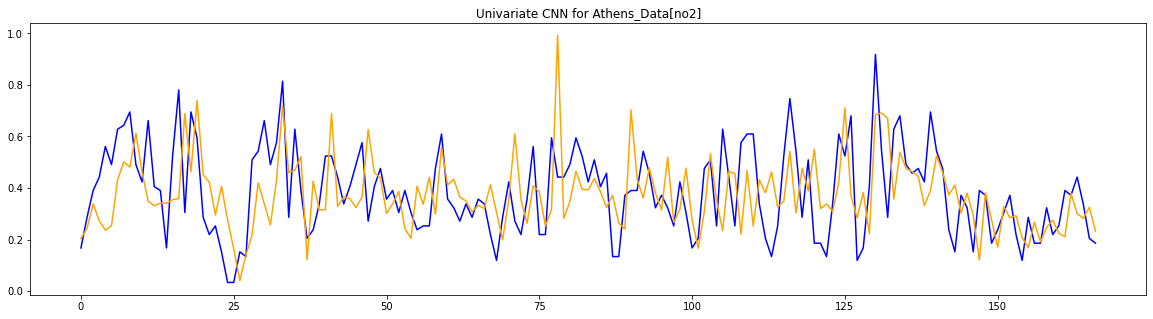

Univariate CNN MSE for Athens[o3]:0.012061467
Univariate CNN RMSE for Athens[o3]:0.10982471212906843
Univariate CNN MAE for Athens[o3]:0.08454076


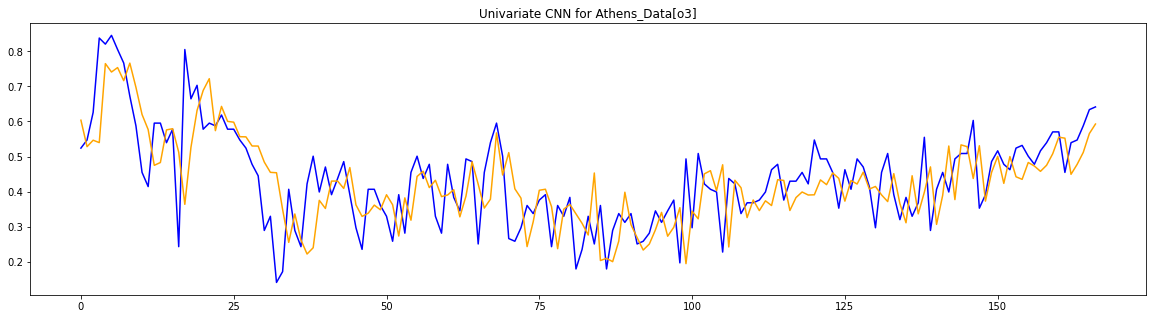

Univariate CNN MSE for Athens[pm10]:0.020125732
Univariate CNN RMSE for Athens[pm10]:0.14186518891478822
Univariate CNN MAE for Athens[pm10]:0.10240229


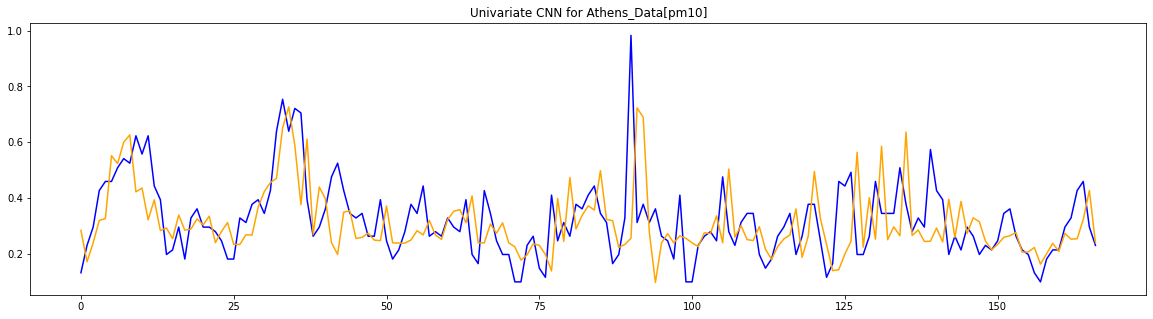

Univariate CNN MSE for Athens[pm25]:0.014293904
Univariate CNN RMSE for Athens[pm25]:0.11955711779841091
Univariate CNN MAE for Athens[pm25]:0.0930642


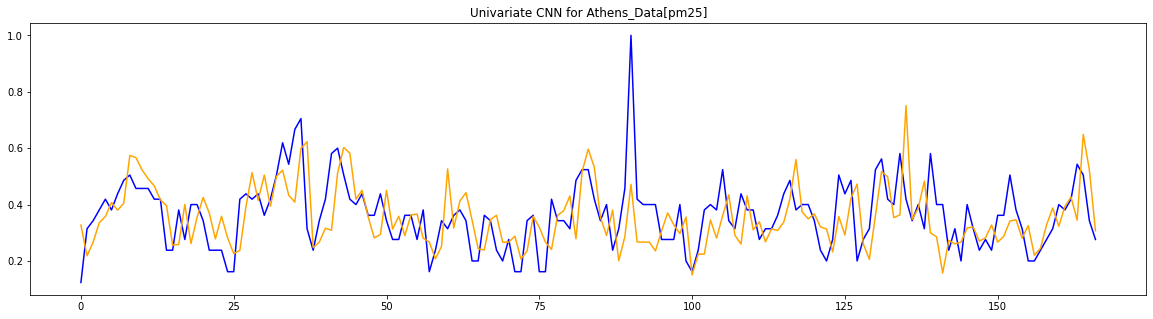

Univariate CNN MSE for Athens[so2]:0.023953743
Univariate CNN RMSE for Athens[so2]:0.15476996891832812
Univariate CNN MAE for Athens[so2]:0.09994434


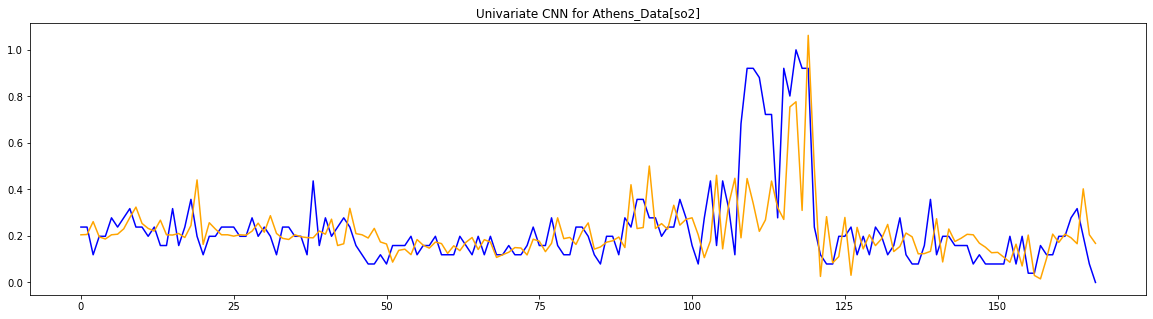

Multivariate CNN MSE for Athens[o3]:0.0013231656
Multivariate CNN RMSE for Athens[o3]:0.03637534336394214
Multivariate CNN MAE for Athens[o3]:0.028076021


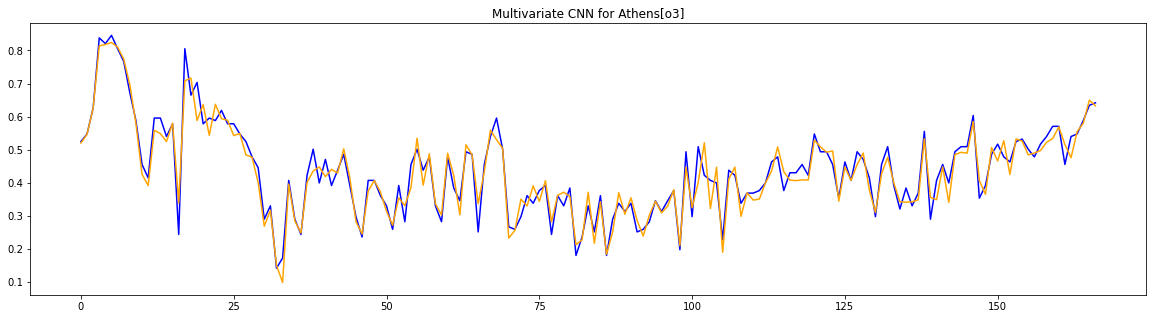

Multivariate CNN MSE for Athens[no2]:0.0017991749
Multivariate CNN RMSE for Athens[no2]:0.04241668225703542
Multivariate CNN MAE for Athens[no2]:0.033982728


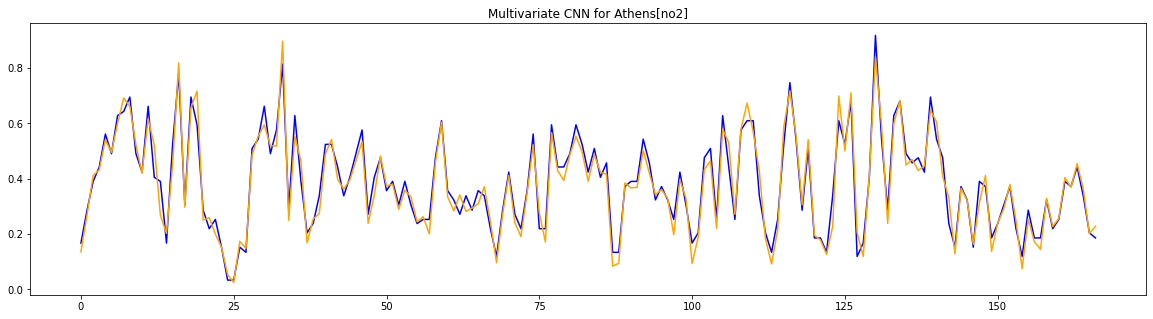

Multivariate CNN MSE for Athens[so2]:0.0018709701
Multivariate CNN RMSE for Athens[so2]:0.04325471217463044
Multivariate CNN MAE for Athens[so2]:0.029961072


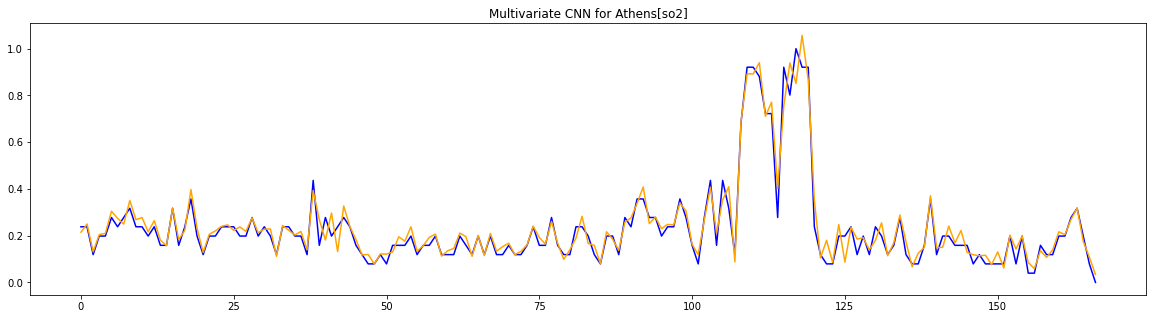

Multivariate CNN MSE for Athens[pm10]:0.0012786943
Multivariate CNN RMSE for Athens[pm10]:0.03575883462048042
Multivariate CNN MAE for Athens[pm10]:0.027485756


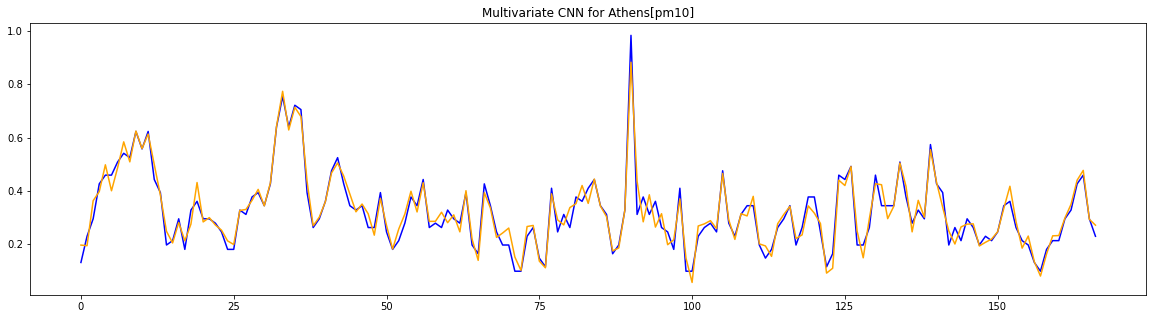

Multivariate CNN MSE for Athens[pm25]:0.0016125999
Multivariate CNN RMSE for Athens[pm25]:0.0401571903786594
Multivariate CNN MAE for Athens[pm25]:0.029857796


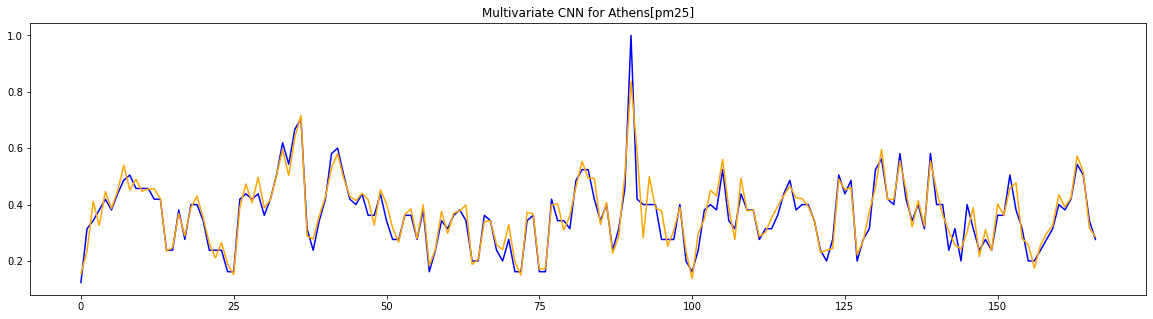

Univariate LSTM MSE for Athens[no2]:0.024083517
Univariate LSTM RMSE for Athens[no2]:0.1551886512984035
Univariate LSTM MAE for Athens[no2]:0.12337824


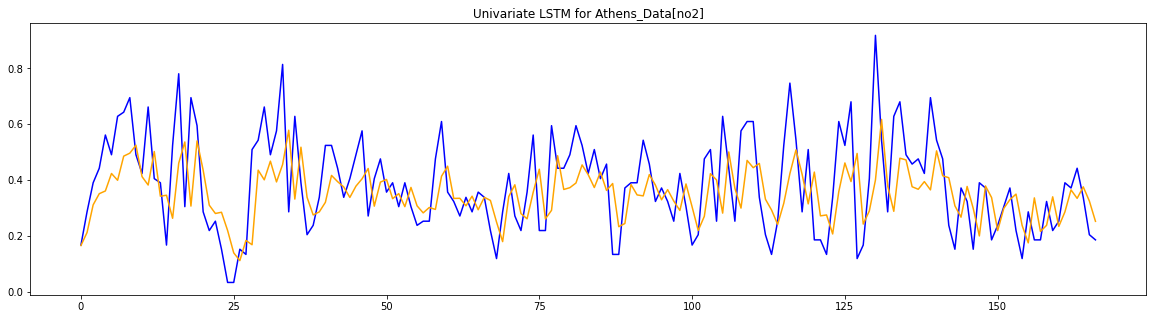

Univariate LSTM MSE for Athens[o3]:0.009132696
Univariate LSTM RMSE for Athens[o3]:0.09556514173926689
Univariate LSTM MAE for Athens[o3]:0.07174944


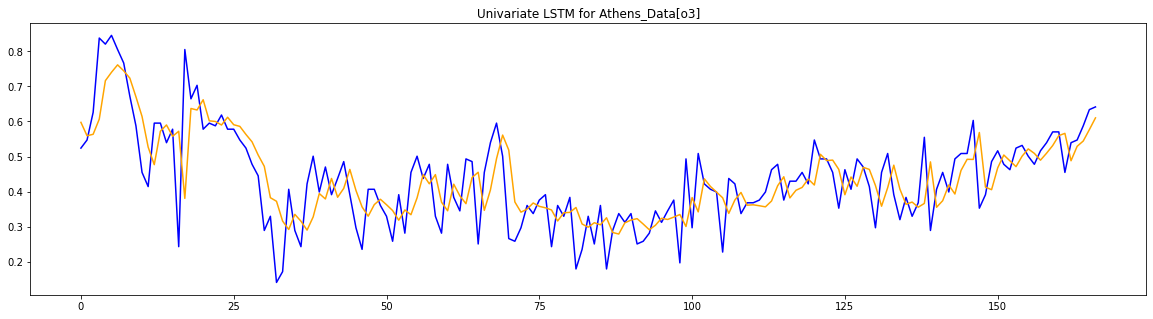

Univariate LSTM MSE for Athens[pm10]:0.013259569
Univariate LSTM RMSE for Athens[pm10]:0.11515020270495394
Univariate LSTM MAE for Athens[pm10]:0.08169723


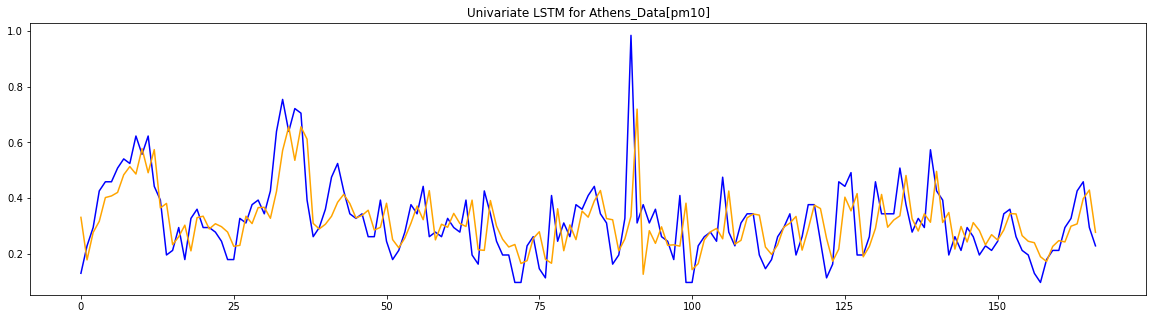

Univariate LSTM MSE for Athens[pm25]:0.0112834135
Univariate LSTM RMSE for Athens[pm25]:0.106223413177342
Univariate LSTM MAE for Athens[pm25]:0.07782953


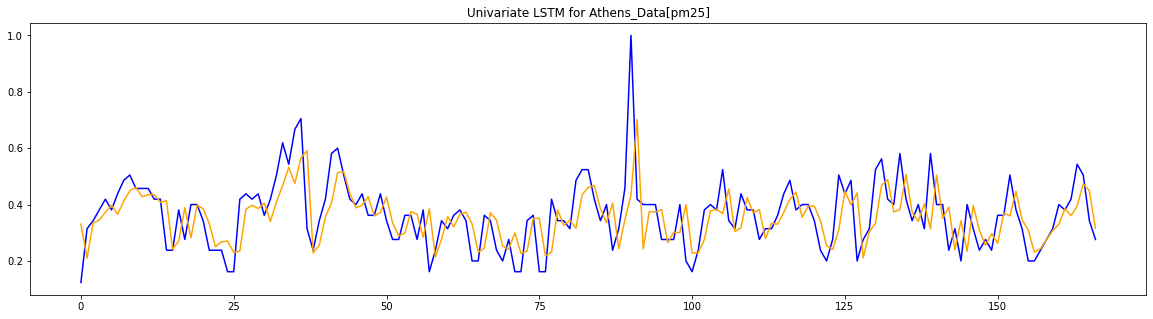

Univariate LSTM MSE for Athens[so2]:0.019724065
Univariate LSTM RMSE for Athens[so2]:0.1404423918833375
Univariate LSTM MAE for Athens[so2]:0.08813757


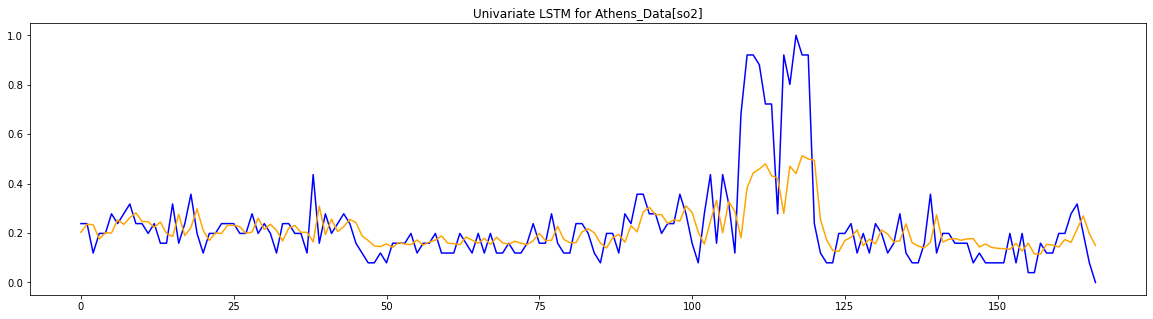

Multivariate LSTM MSE for Athens[o3]:3.1244766e-05
Multivariate LSTM RMSE for Athens[o3]:0.005589701819667302
Multivariate LSTM MAE for Athens[o3]:0.0043363567


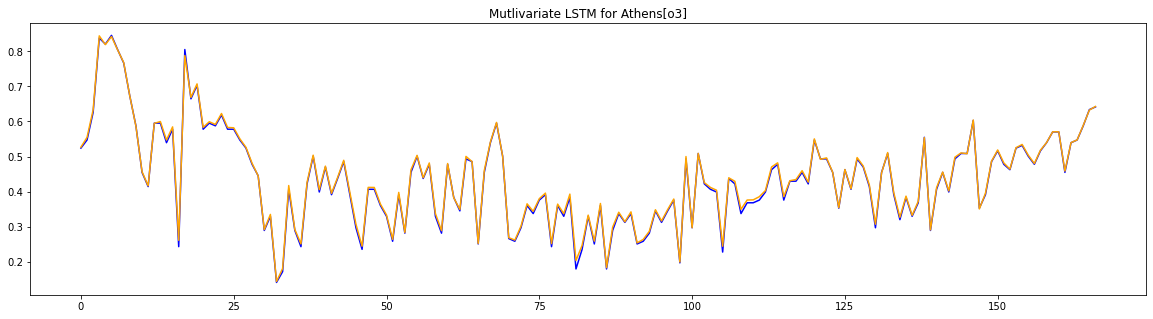

Multivariate LSTM MSE for Athens[no2]:3.7257607e-05
Multivariate LSTM RMSE for Athens[no2]:0.006103900956864939
Multivariate LSTM MAE for Athens[no2]:0.0053307023


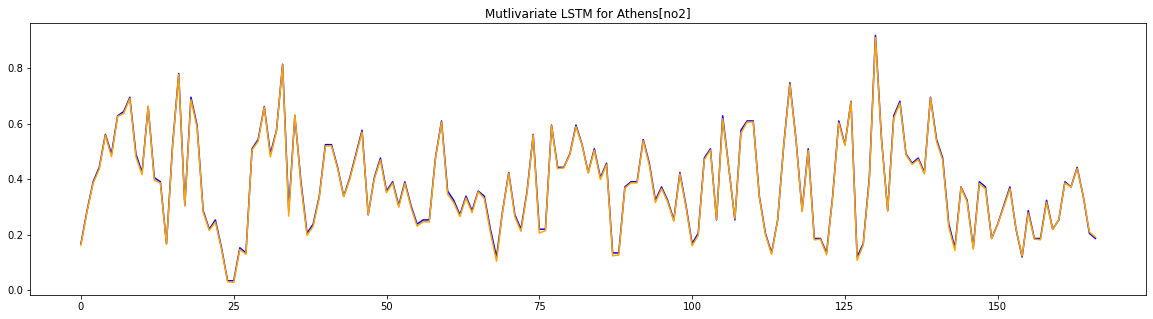

Multivariate LSTM MSE for Athens[so2]:4.405898e-05
Multivariate LSTM RMSE for Athens[so2]:0.006637693820603554
Multivariate LSTM MAE for Athens[so2]:0.0044666235


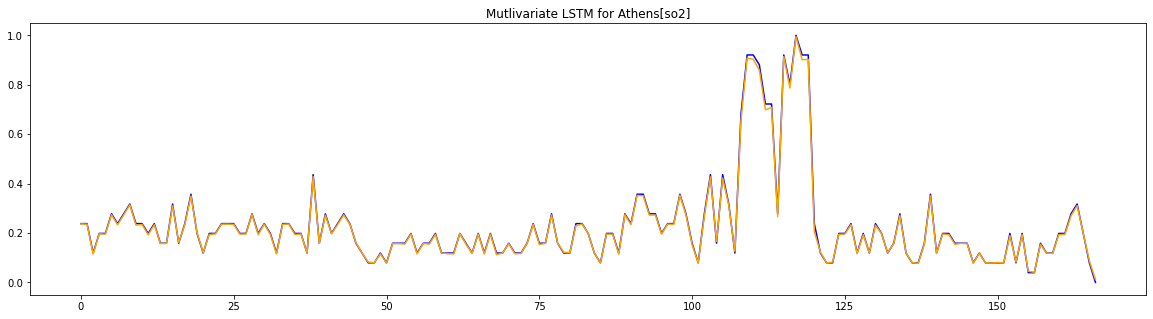

Multivariate LSTM MSE for Athens[pm10]:3.4677534e-05
Multivariate LSTM RMSE for Athens[pm10]:0.00588876337878618
Multivariate LSTM MAE for Athens[pm10]:0.005124589


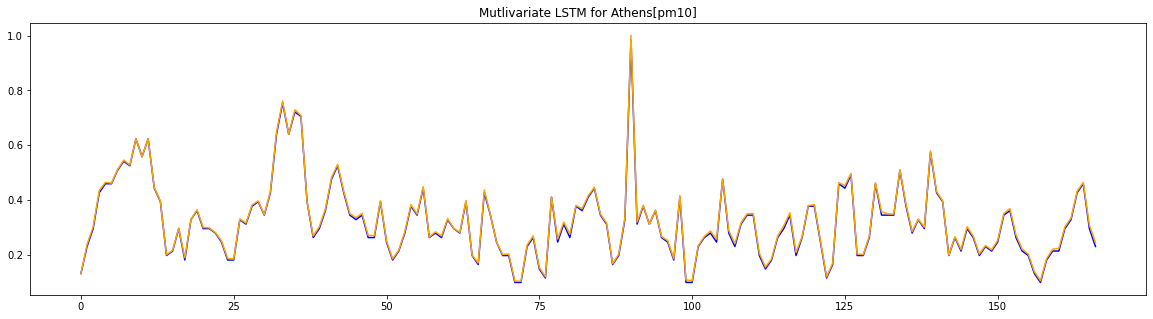

Multivariate LSTM MSE for Athens[pm25]:1.8727475e-05
Multivariate LSTM RMSE for Athens[pm25]:0.004327525219545658
Multivariate LSTM MAE for Athens[pm25]:0.003503125


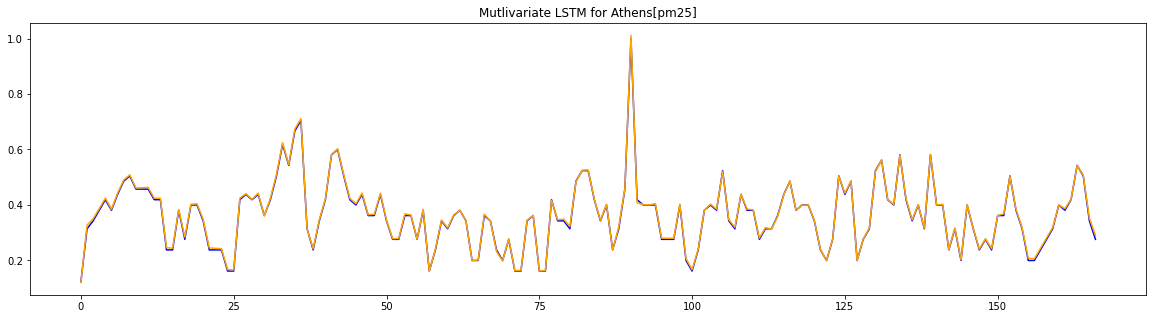

In [18]:
n_steps=7

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()

# Weekly seasonal predictions

In [7]:
Athens_Data_uni.index = pd.to_datetime(Athens_Data_uni.index)
Athens_Data_uni = Athens_Data_uni.resample("1w").mean().bfill()

In [10]:
Athens_o3.index = pd.to_datetime(Athens_o3.index)
Athens_weekly_o3 = Athens_o3.resample("1w").mean().bfill()

Athens_no2.index = pd.to_datetime(Athens_no2.index)
Athens_weekly_no2 = Athens_no2.resample("1w").mean().bfill()

Athens_so2.index = pd.to_datetime(Athens_so2.index)
Athens_weekly_so2 = Athens_so2.resample("1w").mean().bfill()

Athens_pm10.index = pd.to_datetime(Athens_pm10.index)
Athens_weekly_pm10 = Athens_pm10.resample("1w").mean().bfill()

Athens_pm25.index = pd.to_datetime(Athens_pm25.index)
Athens_weekly_pm25 = Athens_pm25.resample("1w").mean().bfill()

datasets = [Athens_weekly_o3.iloc[1: , :], Athens_weekly_no2.iloc[1: , :], 
            Athens_weekly_so2.iloc[1: , :], Athens_weekly_pm10.iloc[1: , :],
            Athens_weekly_pm25.iloc[1: , :]]

Univariate CNN MSE for Athens[no2]:0.022765093
Univariate CNN RMSE for Athens[no2]:0.15088105431666435
Univariate CNN MAE for Athens[no2]:0.1318882


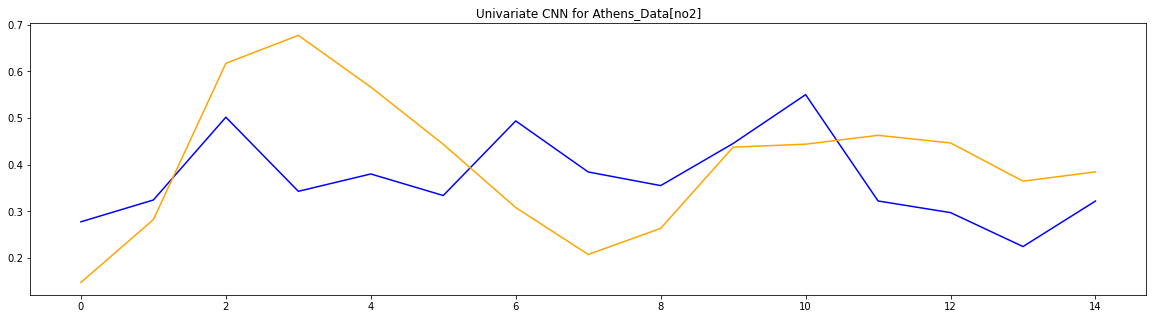

Univariate CNN MSE for Athens[o3]:0.0064241886
Univariate CNN RMSE for Athens[o3]:0.08015103626211954
Univariate CNN MAE for Athens[o3]:0.06776384


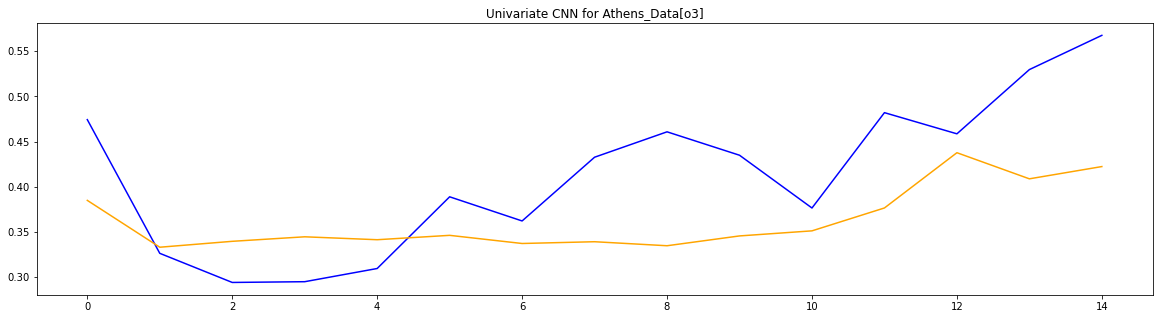

Univariate CNN MSE for Athens[pm10]:0.009255296
Univariate CNN RMSE for Athens[pm10]:0.09620444698333104
Univariate CNN MAE for Athens[pm10]:0.08225725


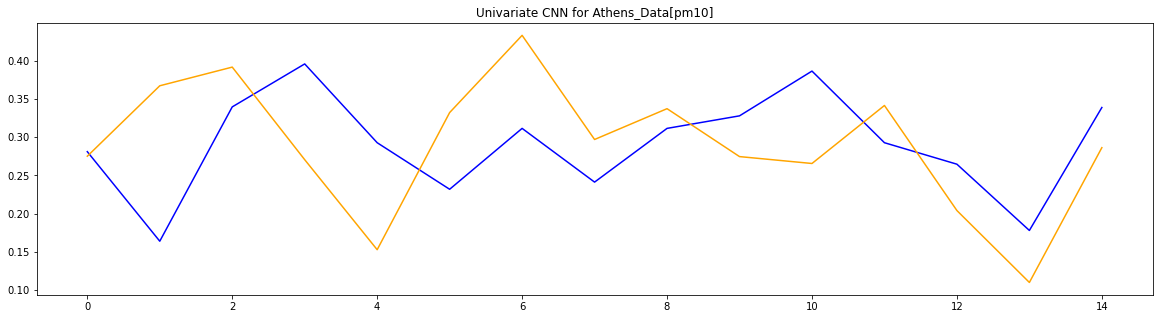

Univariate CNN MSE for Athens[pm25]:0.008018533
Univariate CNN RMSE for Athens[pm25]:0.08954626049083168
Univariate CNN MAE for Athens[pm25]:0.06689556


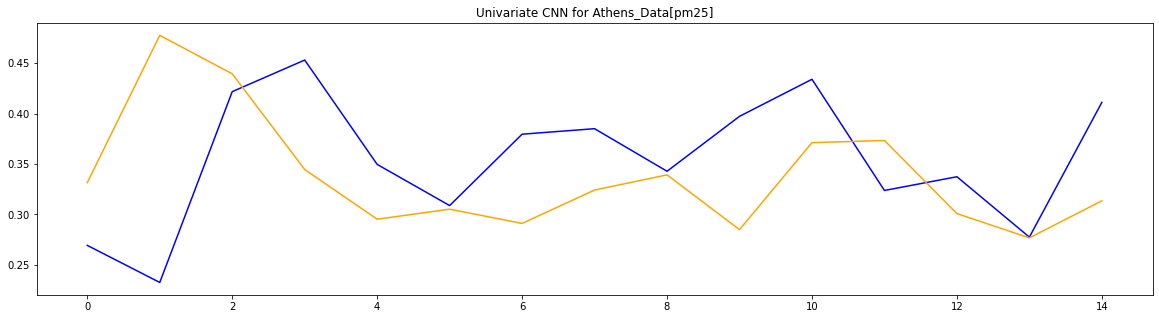

Univariate CNN MSE for Athens[so2]:0.044732932
Univariate CNN RMSE for Athens[so2]:0.21150161229019582
Univariate CNN MAE for Athens[so2]:0.13335444


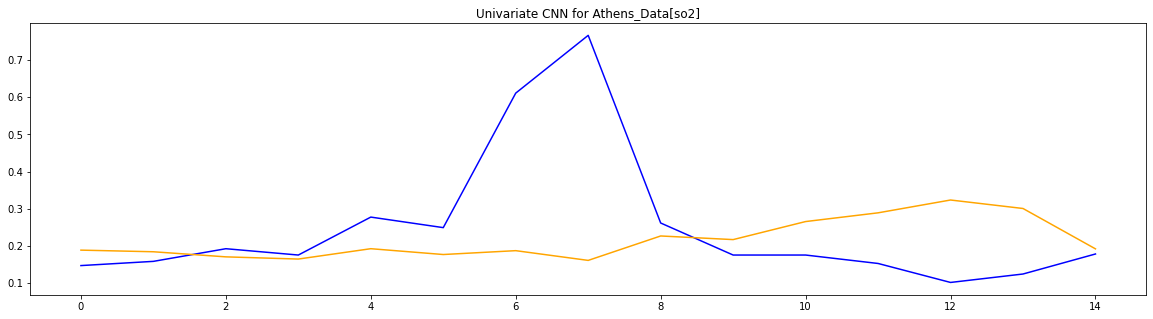

Multivariate CNN MSE for Athens[o3]:0.011531825
Multivariate CNN RMSE for Athens[o3]:0.10738633608318846
Multivariate CNN MAE for Athens[o3]:0.08741306


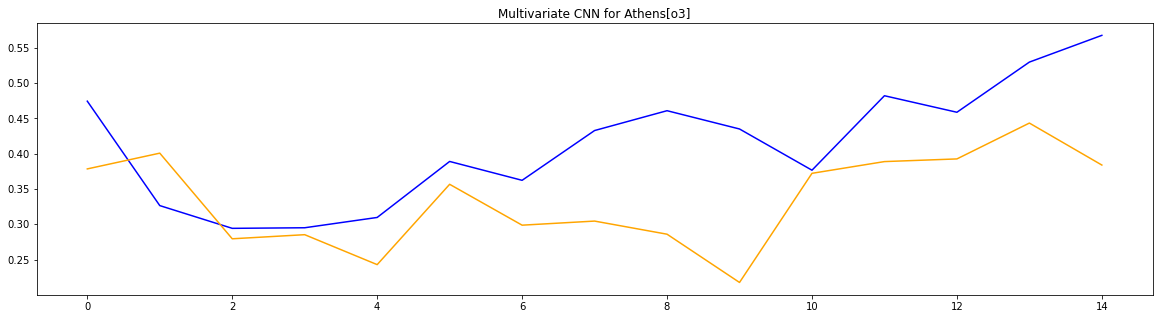

Multivariate CNN MSE for Athens[no2]:0.014882045
Multivariate CNN RMSE for Athens[no2]:0.121991986895374
Multivariate CNN MAE for Athens[no2]:0.09823395


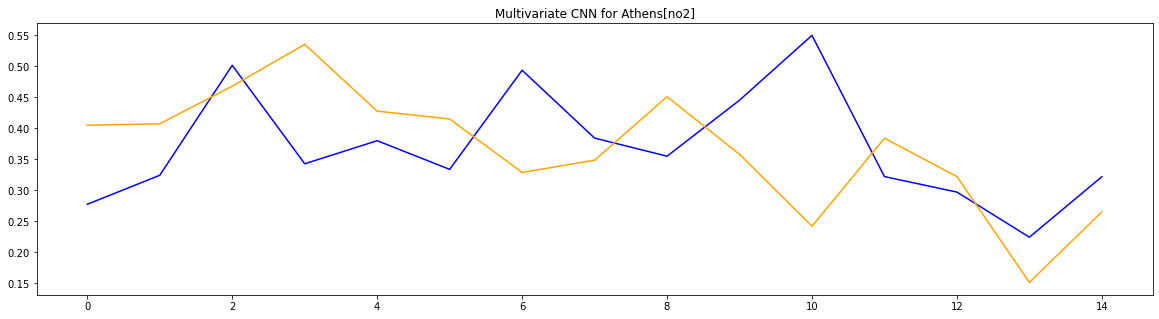

Multivariate CNN MSE for Athens[so2]:0.039082233
Multivariate CNN RMSE for Athens[so2]:0.19769226809036047
Multivariate CNN MAE for Athens[so2]:0.12827195


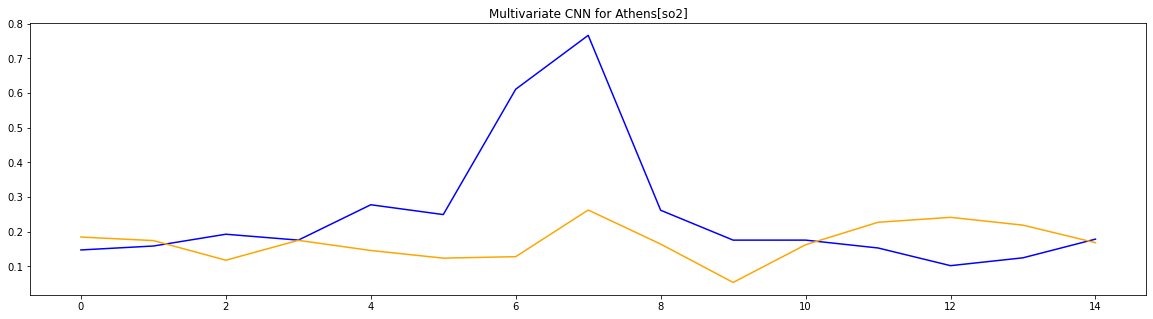

Multivariate CNN MSE for Athens[pm10]:0.015631845
Multivariate CNN RMSE for Athens[pm10]:0.12502737788549922
Multivariate CNN MAE for Athens[pm10]:0.10318958


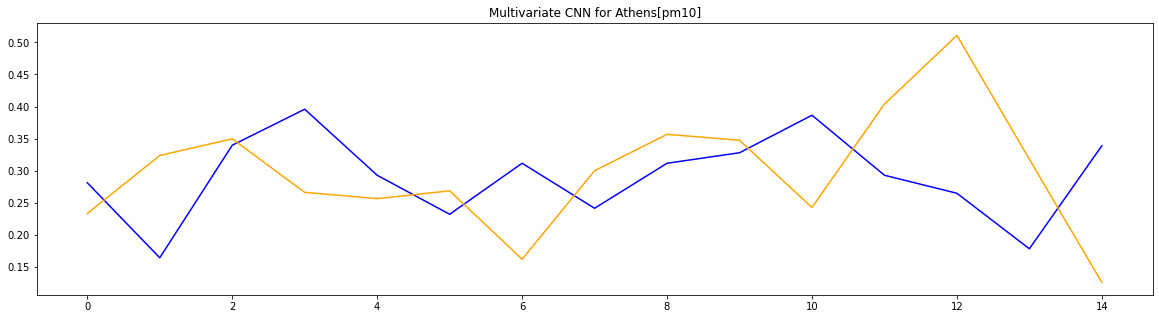

Multivariate CNN MSE for Athens[pm25]:0.008134219
Multivariate CNN RMSE for Athens[pm25]:0.09018990444691077
Multivariate CNN MAE for Athens[pm25]:0.06894091


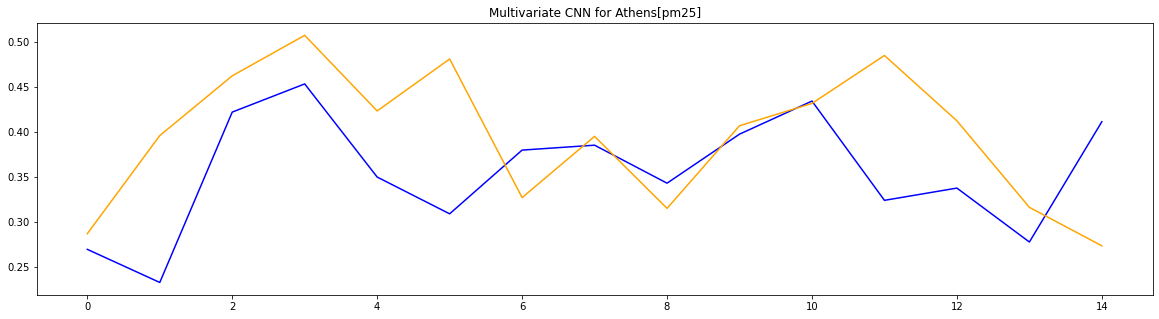

Univariate LSTM MSE for Athens[no2]:0.011485284
Univariate LSTM RMSE for Athens[no2]:0.10716941818611428
Univariate LSTM MAE for Athens[no2]:0.07873348


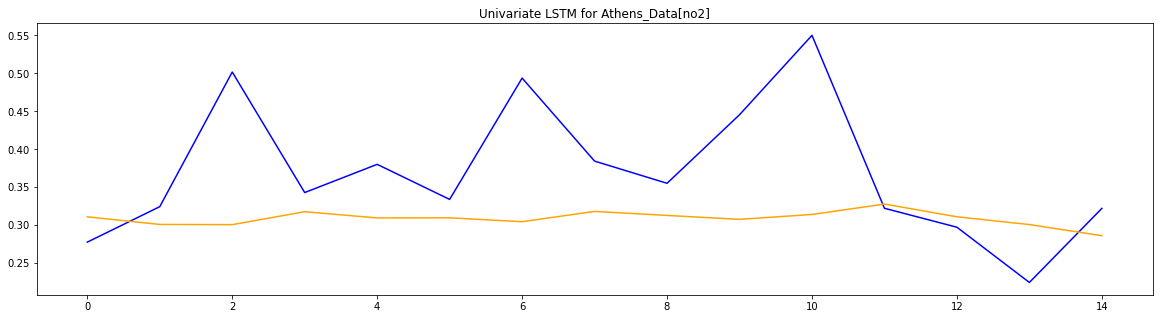

Univariate LSTM MSE for Athens[o3]:0.003862361
Univariate LSTM RMSE for Athens[o3]:0.06214789584539414
Univariate LSTM MAE for Athens[o3]:0.05352847


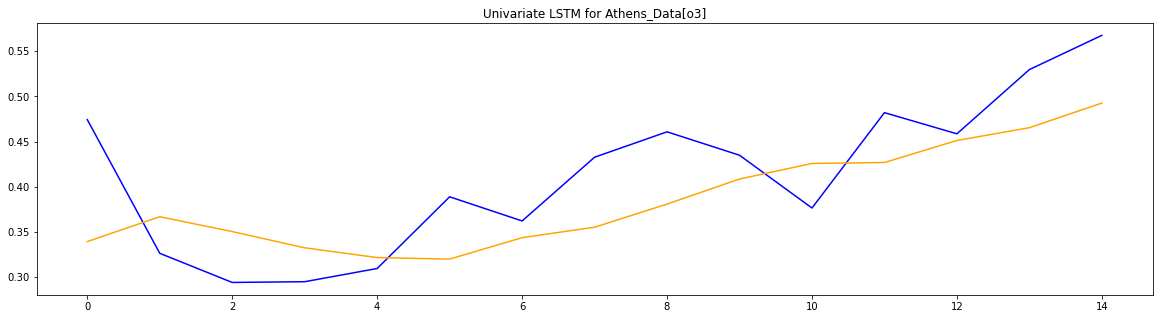

Univariate LSTM MSE for Athens[pm10]:0.0056266566
Univariate LSTM RMSE for Athens[pm10]:0.0750110430584482
Univariate LSTM MAE for Athens[pm10]:0.059199255


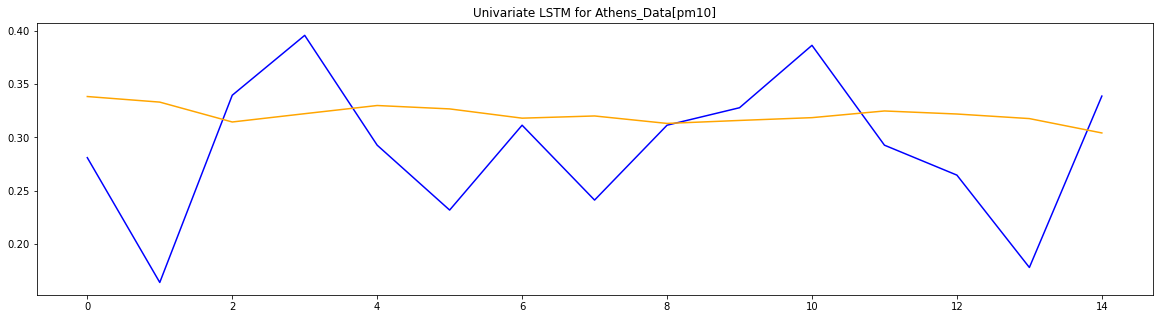

Univariate LSTM MSE for Athens[pm25]:0.0042693787
Univariate LSTM RMSE for Athens[pm25]:0.0653404830517751
Univariate LSTM MAE for Athens[pm25]:0.055890404


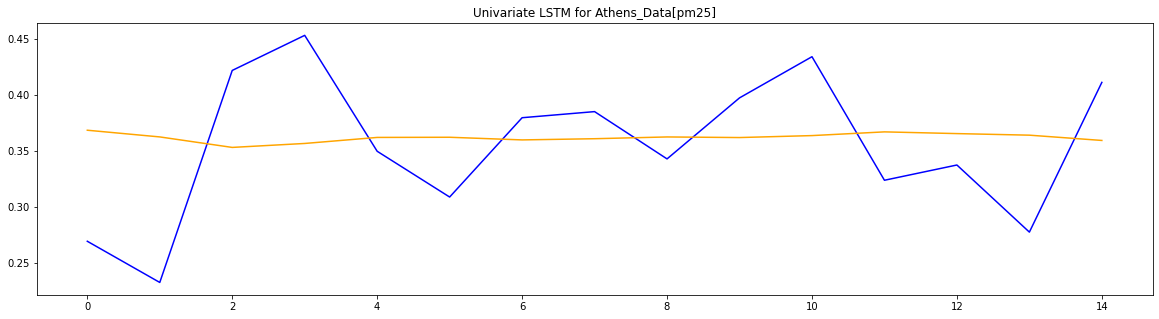

Univariate LSTM MSE for Athens[so2]:0.031838577
Univariate LSTM RMSE for Athens[so2]:0.17843367742863311
Univariate LSTM MAE for Athens[so2]:0.115845636


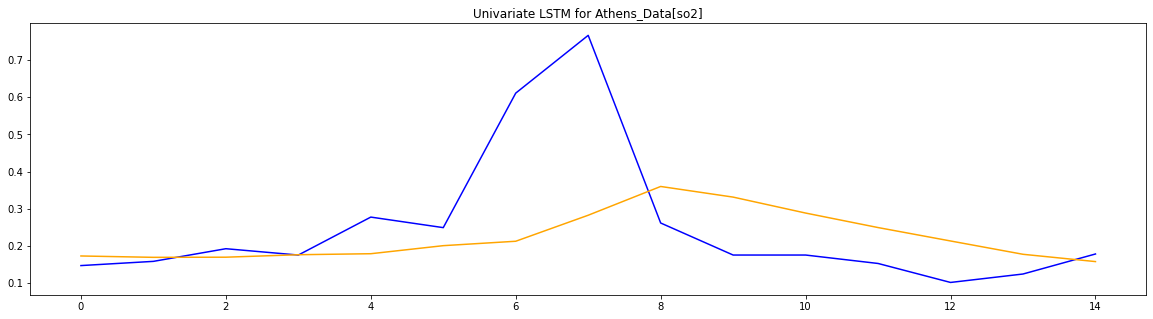

Multivariate LSTM MSE for Athens[o3]:0.0018368468
Multivariate LSTM RMSE for Athens[o3]:0.04285845092186811
Multivariate LSTM MAE for Athens[o3]:0.035786048


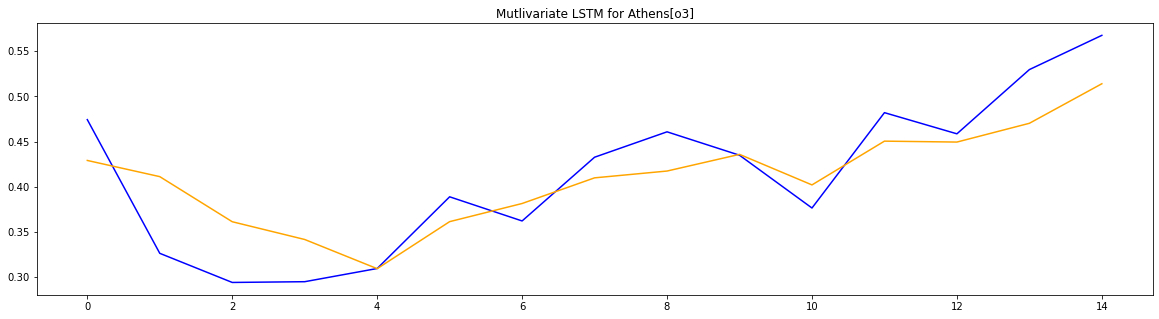

Multivariate LSTM MSE for Athens[no2]:0.0016076473
Multivariate LSTM RMSE for Athens[no2]:0.040095477077488575
Multivariate LSTM MAE for Athens[no2]:0.033151884


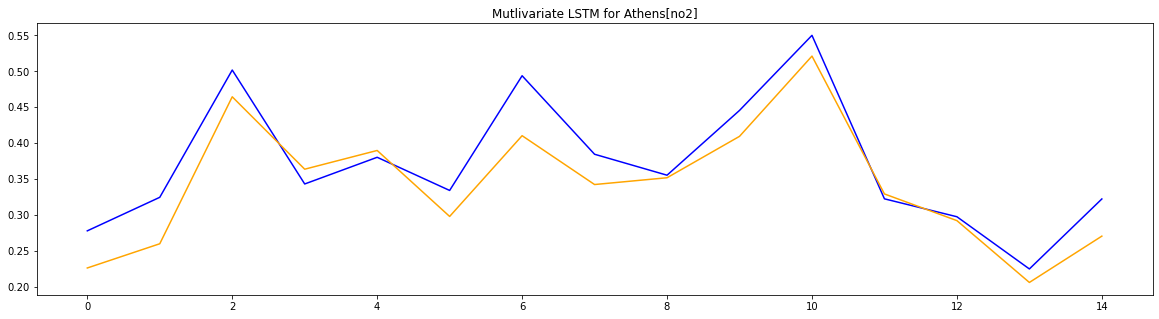

Multivariate LSTM MSE for Athens[so2]:0.017168831
Multivariate LSTM RMSE for Athens[so2]:0.1310298862099723
Multivariate LSTM MAE for Athens[so2]:0.07007871


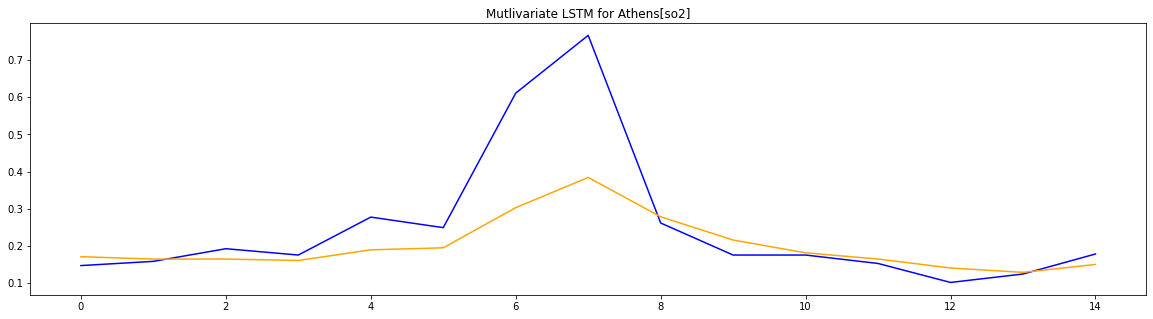

Multivariate LSTM MSE for Athens[pm10]:0.00060058635
Multivariate LSTM RMSE for Athens[pm10]:0.02450686341143746
Multivariate LSTM MAE for Athens[pm10]:0.018124282


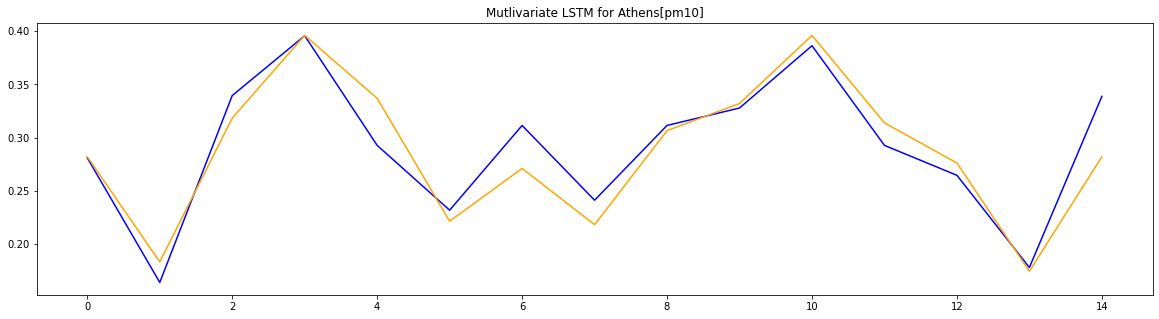

Multivariate LSTM MSE for Athens[pm25]:0.000704365
Multivariate LSTM RMSE for Athens[pm25]:0.026539876144023672
Multivariate LSTM MAE for Athens[pm25]:0.022512745


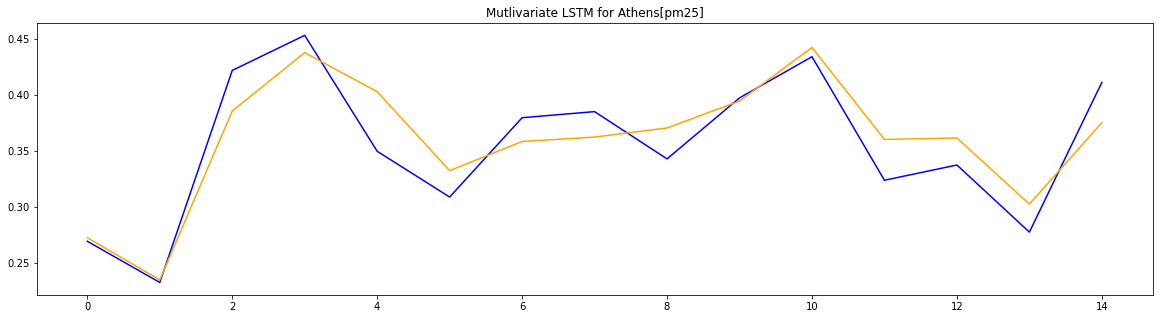

In [16]:
n_steps = 51

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()

# Monthly seasonal predictions

In [31]:
Athens_Data_uni.index = pd.to_datetime(Athens_Data_uni.index)
Athens_Data_uni = Athens_Data_uni.resample("1m").mean().bfill()

In [32]:
Athens_o3.index = pd.to_datetime(Athens_o3.index)
Athens_monthly_o3 = Athens_o3.resample("1m").mean().bfill()

Athens_no2.index = pd.to_datetime(Athens_no2.index)
Athens_monthly_no2 = Athens_no2.resample("1m").mean().bfill()

Athens_so2.index = pd.to_datetime(Athens_so2.index)
Athens_monthly_so2 = Athens_so2.resample("1m").mean().bfill()

Athens_pm10.index = pd.to_datetime(Athens_pm10.index)
Athens_monthly_pm10 = Athens_pm10.resample("1m").mean().bfill()

Athens_pm25.index = pd.to_datetime(Athens_pm25.index)
Athens_monthly_pm25 = Athens_pm25.resample("1m").mean().bfill()

datasets = [Athens_monthly_o3.iloc[1: , :], Athens_monthly_no2.iloc[1: , :], 
            Athens_monthly_so2.iloc[1: , :], Athens_monthly_pm10.iloc[1: , :],
            Athens_monthly_pm25.iloc[1: , :]]

Univariate CNN MSE for Athens[no2]:0.013096973
Univariate CNN RMSE for Athens[no2]:0.11444200845834611
Univariate CNN MAE for Athens[no2]:0.11351662


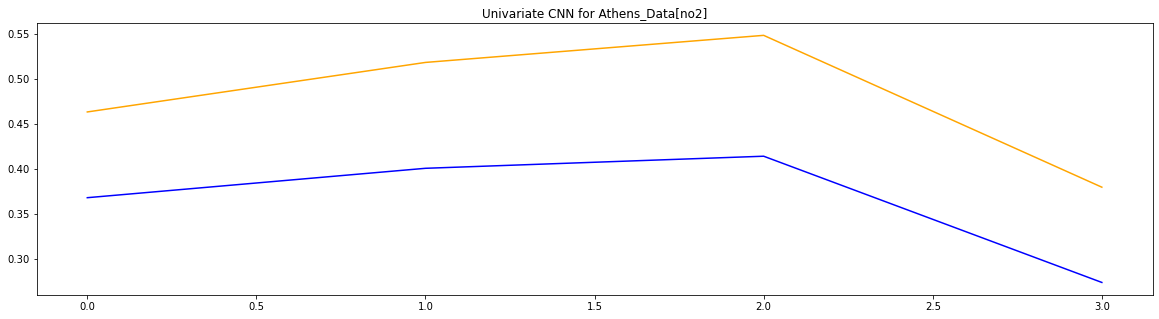

Univariate CNN MSE for Athens[o3]:0.00540638
Univariate CNN RMSE for Athens[o3]:0.07352809099499537
Univariate CNN MAE for Athens[o3]:0.057456158


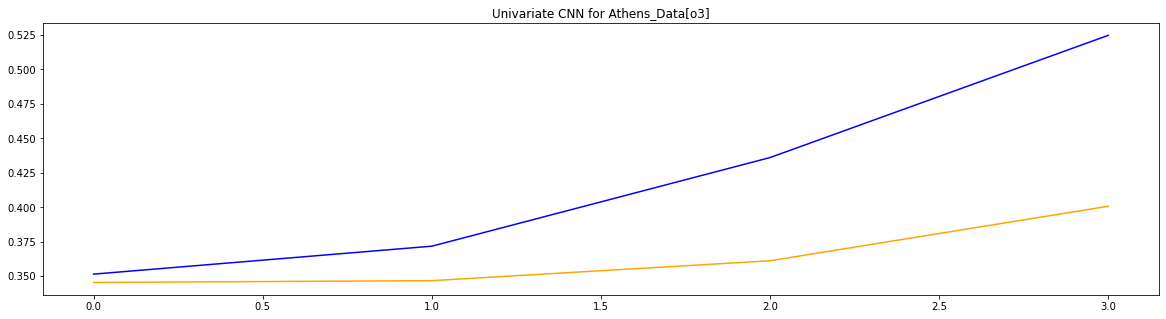

Univariate CNN MSE for Athens[pm10]:0.0060631065
Univariate CNN RMSE for Athens[pm10]:0.0778659519290043
Univariate CNN MAE for Athens[pm10]:0.060632147


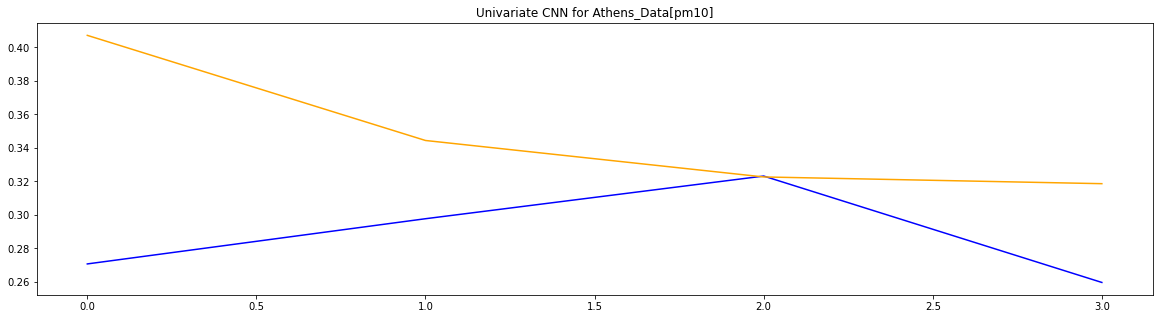

Univariate CNN MSE for Athens[pm25]:0.004503176
Univariate CNN RMSE for Athens[pm25]:0.0671057082663288
Univariate CNN MAE for Athens[pm25]:0.046462573


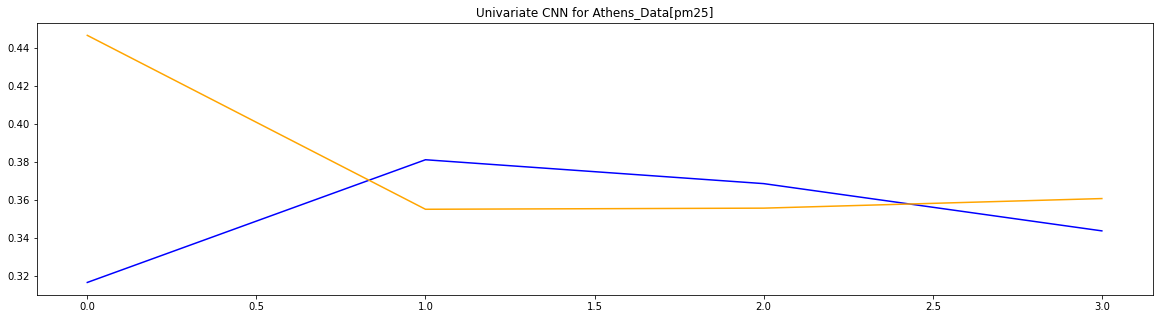

Univariate CNN MSE for Athens[so2]:0.02048582
Univariate CNN RMSE for Athens[so2]:0.1431286842275965
Univariate CNN MAE for Athens[so2]:0.10372466


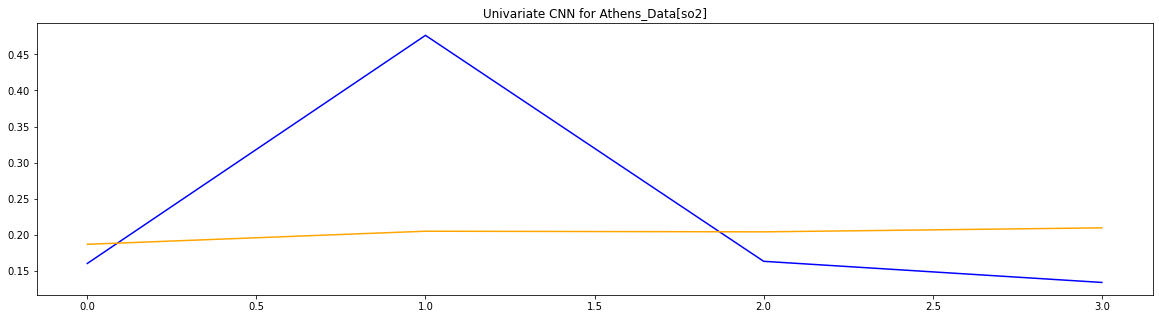

Multivariate CNN MSE for Athens[o3]:0.028874217
Multivariate CNN RMSE for Athens[o3]:0.16992414955283006
Multivariate CNN MAE for Athens[o3]:0.16577959


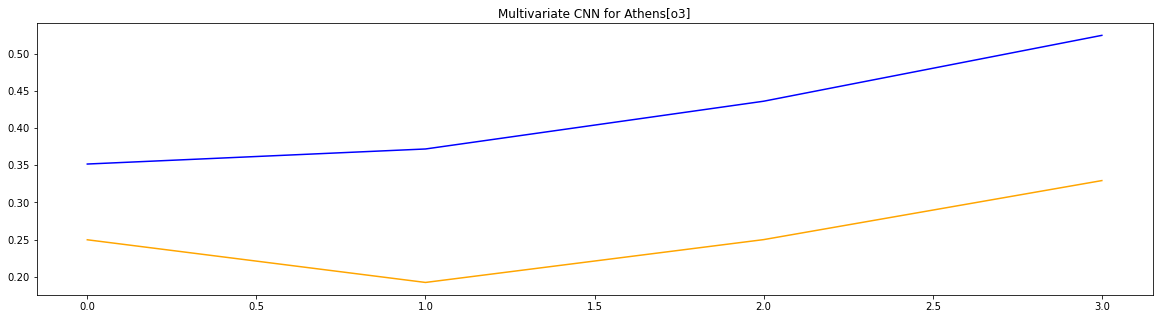

Multivariate CNN MSE for Athens[no2]:0.007835526
Multivariate CNN RMSE for Athens[no2]:0.08851850664880646
Multivariate CNN MAE for Athens[no2]:0.07831118


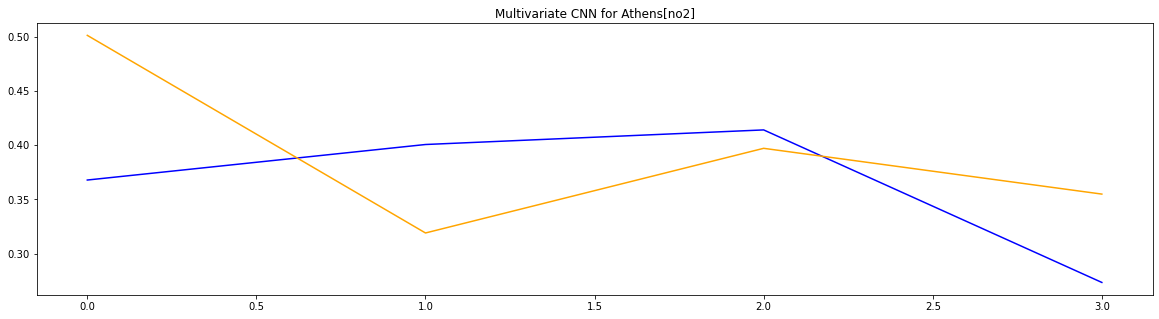

Multivariate CNN MSE for Athens[so2]:0.021081908
Multivariate CNN RMSE for Athens[so2]:0.1451961007557373
Multivariate CNN MAE for Athens[so2]:0.09995822


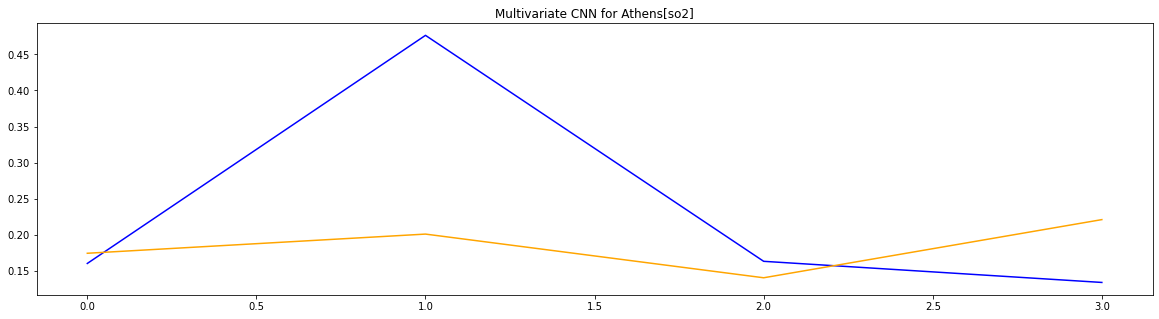

Multivariate CNN MSE for Athens[pm10]:0.005958676
Multivariate CNN RMSE for Athens[pm10]:0.0771924599461276
Multivariate CNN MAE for Athens[pm10]:0.061261795


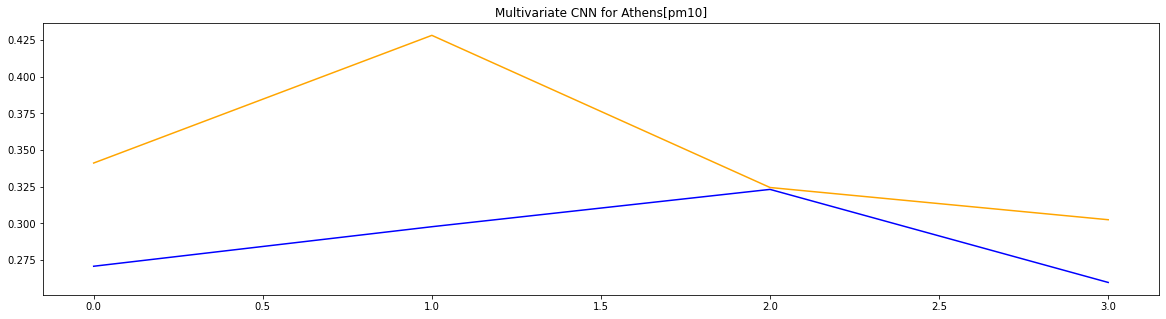

Multivariate CNN MSE for Athens[pm25]:0.0026646643
Multivariate CNN RMSE for Athens[pm25]:0.05162038642407362
Multivariate CNN MAE for Athens[pm25]:0.045951836


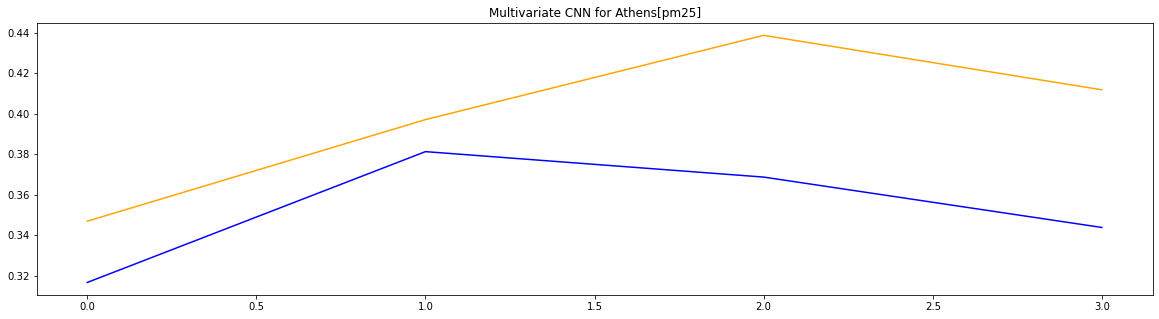

Univariate LSTM MSE for Athens[no2]:0.008616096
Univariate LSTM RMSE for Athens[no2]:0.09282293003412379
Univariate LSTM MAE for Athens[no2]:0.084303565


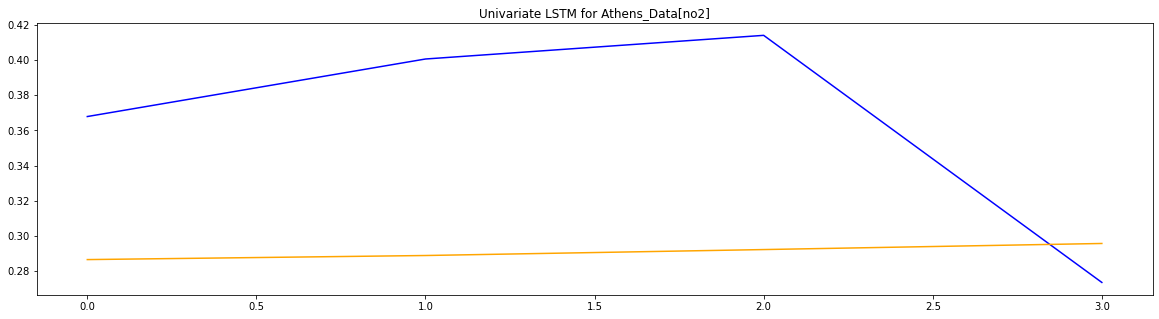

Univariate LSTM MSE for Athens[o3]:0.013641759
Univariate LSTM RMSE for Athens[o3]:0.11679794014409954
Univariate LSTM MAE for Athens[o3]:0.105708


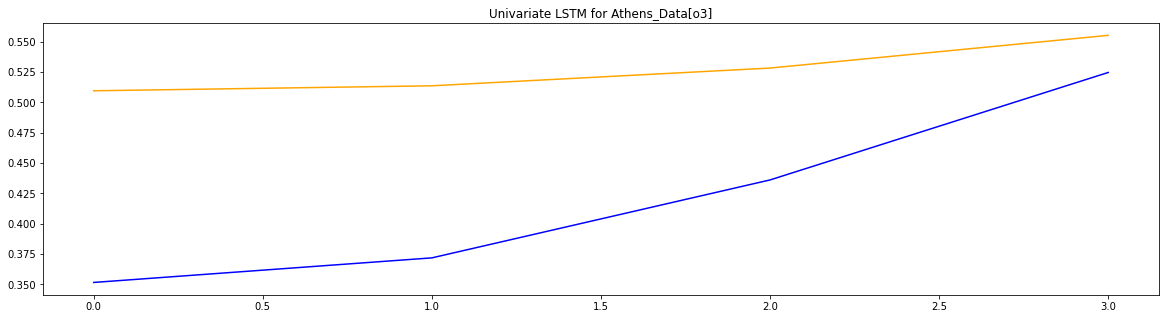

Univariate LSTM MSE for Athens[pm10]:0.0036339657
Univariate LSTM RMSE for Athens[pm10]:0.06028238331484327
Univariate LSTM MAE for Athens[pm10]:0.05436971


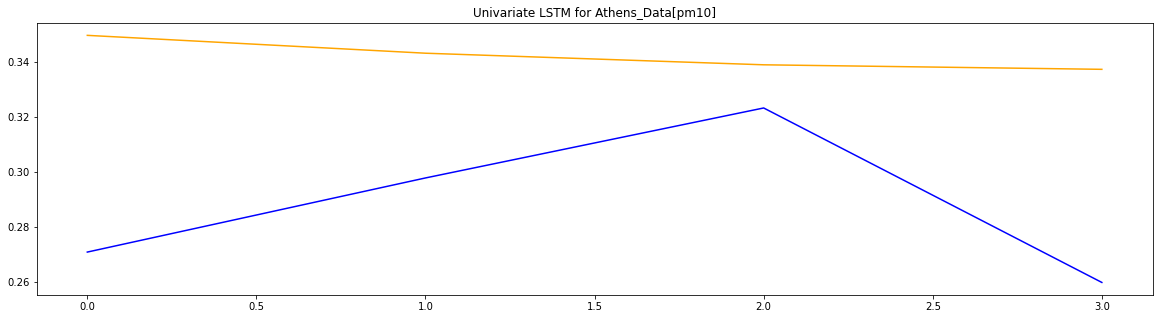

Univariate LSTM MSE for Athens[pm25]:0.0006459784
Univariate LSTM RMSE for Athens[pm25]:0.025416104663565982
Univariate LSTM MAE for Athens[pm25]:0.022969104


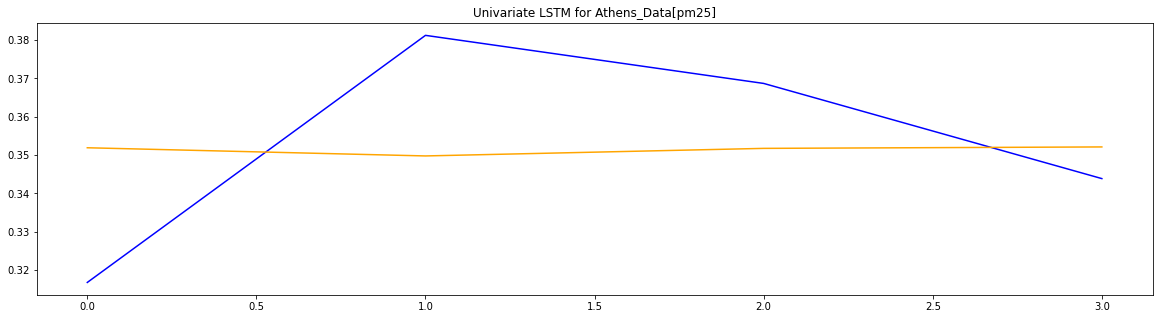

Univariate LSTM MSE for Athens[so2]:0.021361891
Univariate LSTM RMSE for Athens[so2]:0.1461570770790004
Univariate LSTM MAE for Athens[so2]:0.11441595


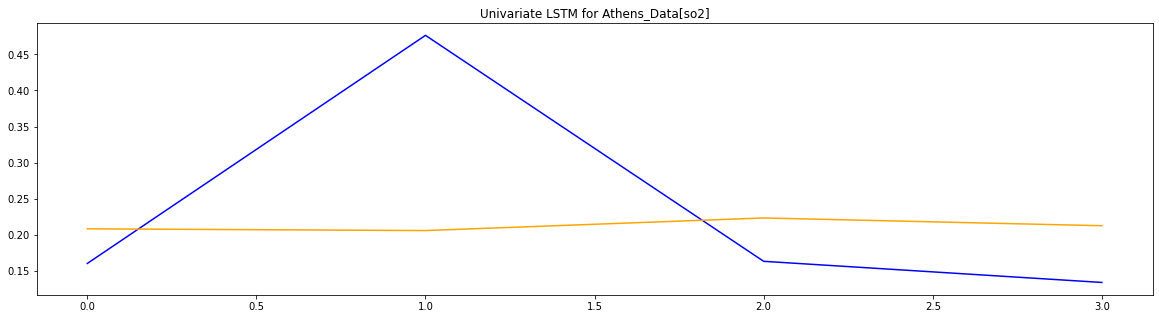

Multivariate LSTM MSE for Athens[o3]:0.0015683253
Multivariate LSTM RMSE for Athens[o3]:0.03960208743957776
Multivariate LSTM MAE for Athens[o3]:0.03400807


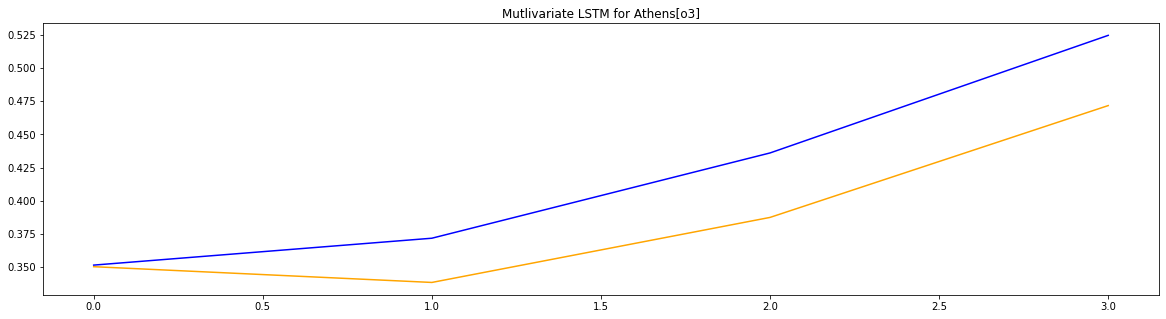

Multivariate LSTM MSE for Athens[no2]:0.0024043098
Multivariate LSTM RMSE for Athens[no2]:0.0490337619320394
Multivariate LSTM MAE for Athens[no2]:0.041574903


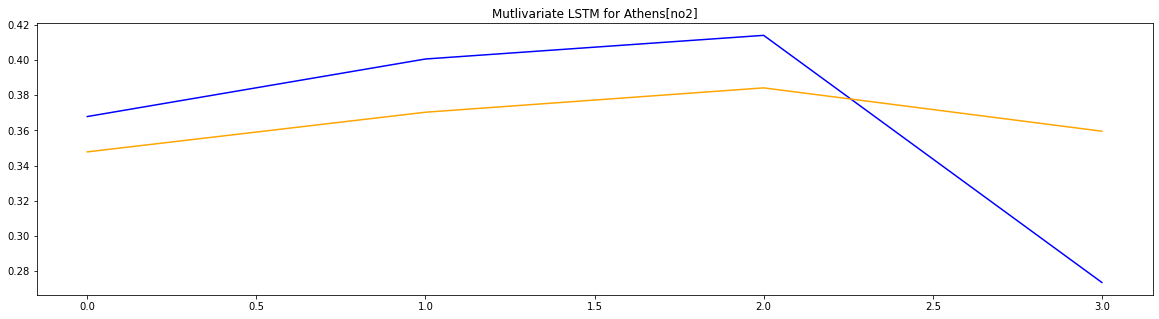

Multivariate LSTM MSE for Athens[so2]:0.022484303
Multivariate LSTM RMSE for Athens[so2]:0.14994766593966027
Multivariate LSTM MAE for Athens[so2]:0.096114725


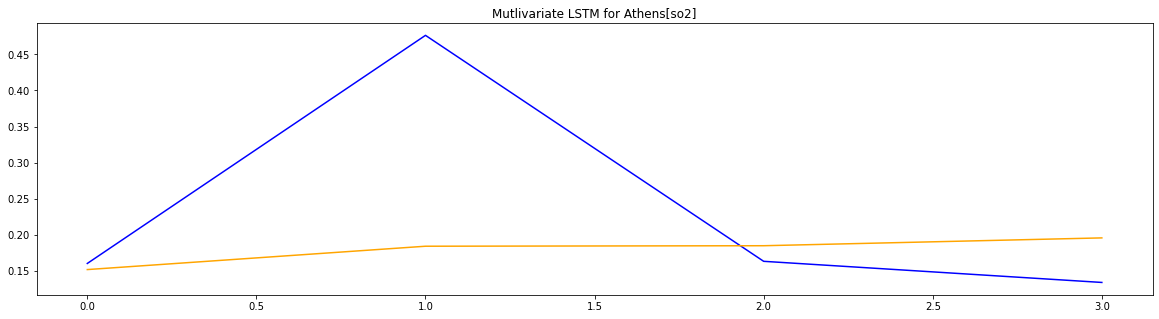

Multivariate LSTM MSE for Athens[pm10]:0.0009077104
Multivariate LSTM RMSE for Athens[pm10]:0.030128232675271326
Multivariate LSTM MAE for Athens[pm10]:0.024379723


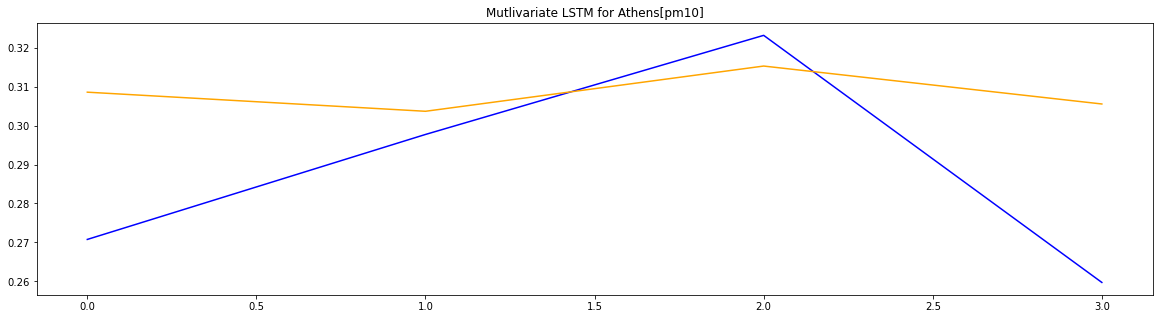

Multivariate LSTM MSE for Athens[pm25]:0.00066853507
Multivariate LSTM RMSE for Athens[pm25]:0.025856045081067373
Multivariate LSTM MAE for Athens[pm25]:0.022259332


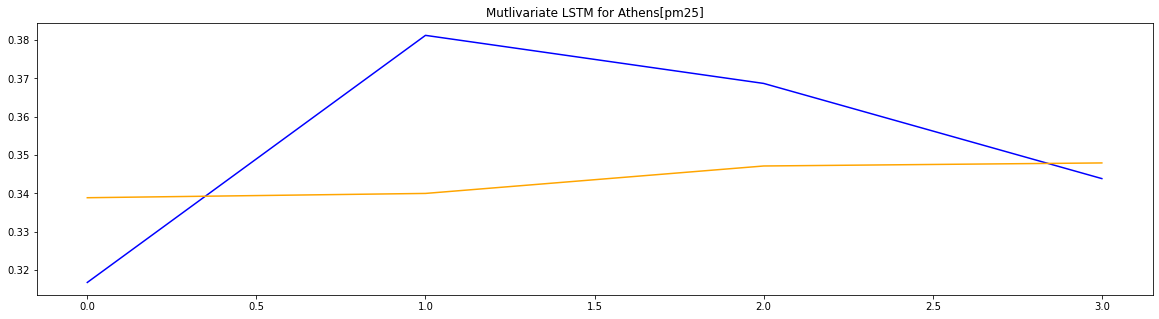

In [33]:
n_steps = 12

pred_ucnn,test_ucnn = Uni_CNN()
pred_mcnn,test_mcnn = Multi_CNN()
pred_ulstm,test_ulstm = Uni_LSTM()
pred_mlstm,test_mlstm = Multi_LSTM()